[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB
None

Data after removing missing values: 3149 rows, 5 columns


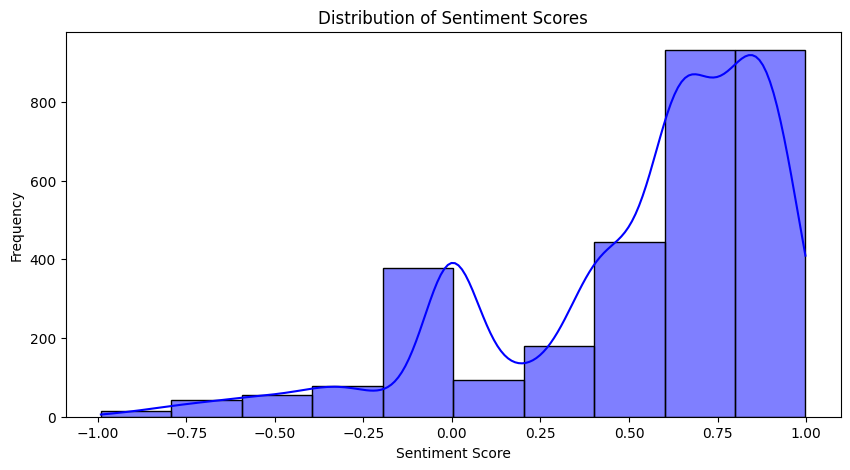

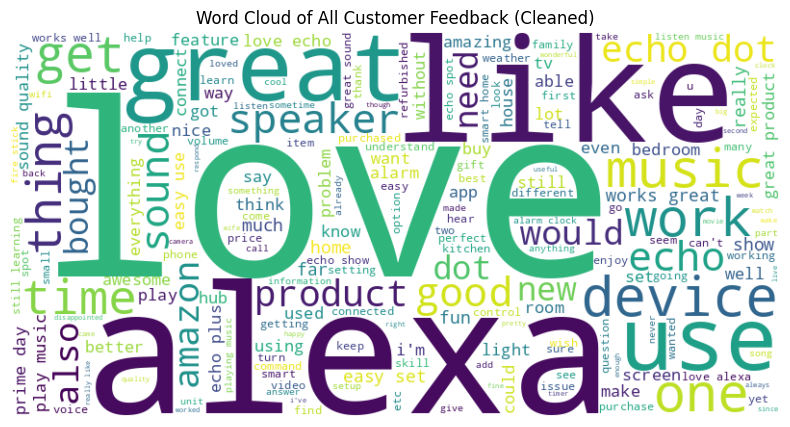

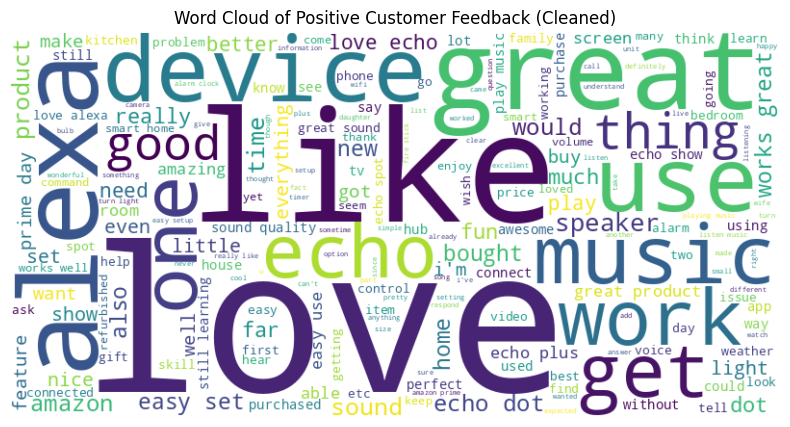

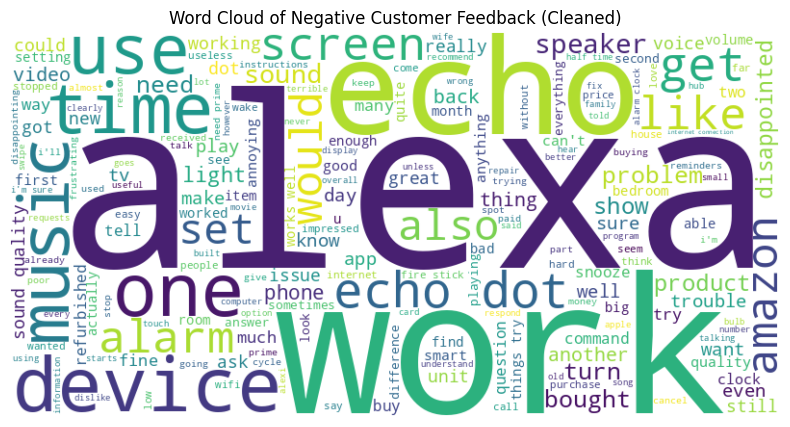

Fitting 3 folds for each of 50 candidates, totalling 150 fits

Mean Squared Error: 0.0592
R² Score (Accuracy): 0.6454


<ipython-input-10-1f4171e54233>:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_df, palette='coolwarm')


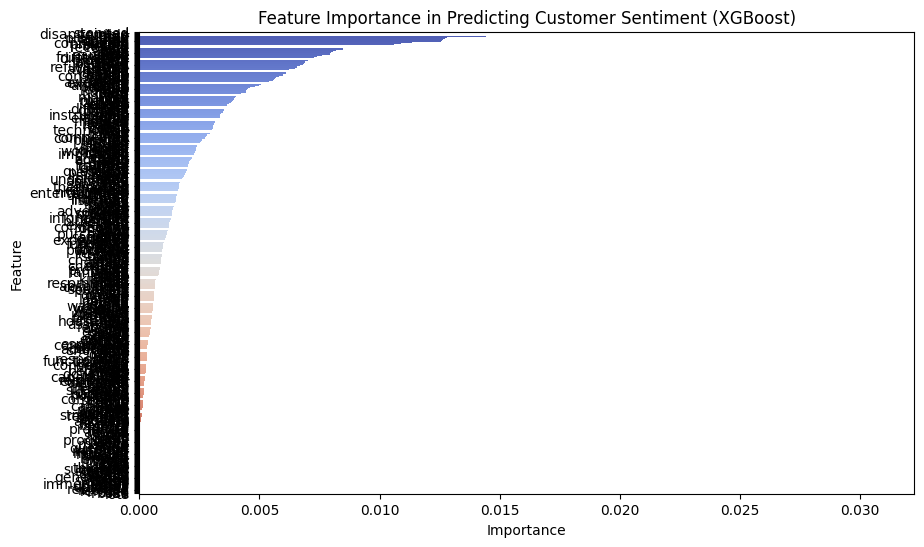


Dynamic Insights Based on Negative Feedback (Using Cleaned Data):
- 'Battery' frequently appears in negative feedback. Consider improving battery life.
- 'Price' frequently appears in negative feedback. Reducing price might improve satisfaction.
- 'Warranty' concerns frequently appear. Addressing warranty issues could help.
- 'Performance' concerns frequently appear. Addressing performance issues could help.
- 'Speaker' concerns frequently appear. Addressing speaker quality could help.
- 'Quality' concerns frequently appear. Addressing quality issues could help.

Overall Conclusion: Focus on addressing negative sentiment around frequent issues to improve product satisfaction.

Review: 'I love the sleek design and the AR functionality is amazing.'
Predicted Sentiment Score: 0.86
Sentiment: Positive (Score: 0.84)

Review: 'The device is way too expensive for its limited features.'
Predicted Sentiment Score: -0.09
Sentiment: Negative (Score: -0.23)

Review: 'Battery life is terrible, I c

In [ ]:
 # Step 1: Import Required Libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import nltk
import numpy as np
nltk.download('vader_lexicon')

# Step 2: Read Dataset using pandas
df = pd.read_csv('/content/amazon_alexa.tsv', sep='\t')

# Step 3: Data Exploration
print("Dataset Info:")
print(df.info())  # Check for missing values, data types

# Handling missing values
df = df.dropna()  # Remove rows with missing values
print(f"\nData after removing missing values: {df.shape[0]} rows, {df.shape[1]} columns")

# Step 4: Sentiment Analysis (VADER) on 'verified_reviews' column
if 'verified_reviews' in df.columns:
    sentiment_analyzer = SentimentIntensityAnalyzer()
    df['sentiment'] = df['verified_reviews'].apply(lambda x: sentiment_analyzer.polarity_scores(x)['compound'])

if 'sentiment' in df.columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(df['sentiment'], bins=10, kde=True, color='blue')
    plt.title('Distribution of Sentiment Scores')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')
    plt.show()

# Step 5: Custom Stopwords List
stopwords = set(nltk.corpus.stopwords.words('english'))  # Pre-defined stopwords from NLTK library

# Step 6: Clean Feedback Function (Removing Stopwords)
def clean_feedback(feedback):
    words = feedback.lower().split()
    cleaned_words = [word for word in words if word not in stopwords]  # Only keep non-stopwords
    return " ".join(cleaned_words)

# Apply cleaning to all feedback text
df['cleaned_feedback'] = df['verified_reviews'].apply(clean_feedback)

# Step 7: Word Cloud Generation for Different Feedback Categories
def generate_wordcloud(feedback_list, title):
    wordcloud = WordCloud(background_color='white', stopwords=stopwords, width=800, height=400).generate(" ".join(feedback_list))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Separate positive and negative feedback
positive_feedback = df[df['sentiment'] > 0.05]['cleaned_feedback']
negative_feedback = df[df['sentiment'] < -0.05]['cleaned_feedback']
all_feedback = df['cleaned_feedback']

# Generate word clouds for all, positive, and negative feedback
generate_wordcloud(all_feedback, "Word Cloud of All Customer Feedback (Cleaned)")
generate_wordcloud(positive_feedback, "Word Cloud of Positive Customer Feedback (Cleaned)")
generate_wordcloud(negative_feedback, "Word Cloud of Negative Customer Feedback (Cleaned)")

# Step 8: Feature Extraction (TF-IDF) from 'cleaned_feedback' column
if 'cleaned_feedback' in df.columns and 'sentiment' in df.columns:
    tfidf = TfidfVectorizer(stop_words='english', max_features=500)  # Increased max_features for better accuracy
    tfidf_matrix = tfidf.fit_transform(df['cleaned_feedback'])
    feature_names = tfidf.get_feature_names_out()

# Step 9: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df['sentiment'], test_size=0.2, random_state=42)

# Step 10: Hyperparameter Tuning for XGBoost using Randomized Search
param_dist = {
    'n_estimators': np.arange(100, 500, 50),
    'max_depth': np.arange(3, 15),
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'min_child_weight': [1, 2, 3]
}

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
random_search = RandomizedSearchCV(xgb, param_dist, n_iter=50, cv=3, n_jobs=-1, verbose=2)
random_search.fit(X_train, y_train)

# Step 11: Train XGBoost with best parameters
best_xgb = random_search.best_estimator_
best_xgb.fit(X_train, y_train)

# Step 12: Make Predictions
y_pred = best_xgb.predict(X_test)

# Step 13: Calculate Metrics (Mean Squared Error, R² Score)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nMean Squared Error: {mse:.4f}")
print(f"R² Score (Accuracy): {r2:.4f}")

# Step 14: Feature Importance from XGBoost
importance = best_xgb.feature_importances_
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importance})
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Step 15: Visualize Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df, palette='coolwarm')
plt.title('Feature Importance in Predicting Customer Sentiment (XGBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Step 16: Dynamic Insights for Negative Words Only
negative_wordcloud_words = " ".join(negative_feedback)
print("\nDynamic Insights Based on Negative Feedback (Using Cleaned Data):")
if 'battery' in negative_wordcloud_words:
    print("- 'Battery' frequently appears in negative feedback. Consider improving battery life.")
if 'price' in negative_wordcloud_words:
    print("- 'Price' frequently appears in negative feedback. Reducing price might improve satisfaction.")
if 'privacy' in negative_wordcloud_words:
    print("- 'Privacy' concerns frequently appear. Addressing privacy issues could help.")
if 'warranty' in negative_wordcloud_words:  # Fixed typo from 'waranty'
    print("- 'Warranty' concerns frequently appear. Addressing warranty issues could help.")
if 'performance' in negative_wordcloud_words:
    print("- 'Performance' concerns frequently appear. Addressing performance issues could help.")
if 'speaker' in negative_wordcloud_words:
    print("- 'Speaker' concerns frequently appear. Addressing speaker quality could help.")
if 'quality' in negative_wordcloud_words:
    print("- 'Quality' concerns frequently appear. Addressing quality issues could help.")
else:
    print("- General improvements could be made based on other frequent negative feedback.")

print("\nOverall Conclusion: Focus on addressing negative sentiment around frequent issues to improve product satisfaction.")

# Testing with new reviews
test_reviews = [
    "I love the sleek design and the AR functionality is amazing.",
    "The device is way too expensive for its limited features.",
    "Battery life is terrible, I can barely use it for a few hours.",
    "It's a great innovation, but it gets uncomfortable after long use.",
    "The voice commands are unresponsive and the price is not justified.",
    "Alexa is working fine.",
    "It is the worst product.",
    "It is not user-friendly.",
    "Need better improvement in build quality.",
    "I am satisfied with the price and it is justified.",
    "Alexa's sound quality is not good.",
    "Alexa responds well and poorly.",
    "Alexa's warranty is not fair."
]

# Transform new reviews into TF-IDF features
test_tfidf = tfidf.transform(test_reviews)

# Use the trained model to predict sentiment for new reviews
test_pred = best_xgb.predict(test_tfidf)

# Step 17: Sentiment Analysis on test reviews
for i, review in enumerate(test_reviews):
    sentiment = sentiment_analyzer.polarity_scores(review)['compound']
    if sentiment >= 0.05:
        sentiment_label = "Positive"
    elif sentiment <= -0.05:
        sentiment_label = "Negative"
    else:
        sentiment_label = "Neutral"

    print(f"\nReview: '{review}'")
    print(f"Predicted Sentiment Score: {test_pred[i]:.2f}")
    print(f"Sentiment: {sentiment_label} (Score: {sentiment:.2f})")
